# Data Generation

This notebook uses the [Statlog (German Credit Data) Data Set](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)) to prepare training and test datasets for the demo.

It applies SMOTE and general upsampling to balance the dataset and to create a training set of a challenging size. No data pre-processing is done here besides applying proper column names to the dataset and recoding the target variable from {1,2} to {0,1}. This has no impact on the model performance or its metrics.

We start by loading all the Python libraries needed for processing and generating the training/test data. Note, that we are leveraging [Domino datasets](https://docs.dominodatalab.com/en/latest/admin_guide/ae1654/domino-datasets/) as a data store.

In [1]:
pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 6.6 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

import pandas as pd
import numpy as np
import urllib.request

from imblearn.over_sampling import SMOTEN
from sklearn.preprocessing import StandardScaler 
from collections import Counter

# Set for reprudicibility
np.random.seed(1234)

# Setup paths and filenames
DATA_PATH = "/mnt/data/" + os.environ.get("DOMINO_PROJECT_NAME") # Location of the Credit Card Dataset
DATA_FILE = DATA_PATH + "/german.data"
TRAINING_SET = DATA_PATH + "/data/train_data.csv"
TEST_SET = DATA_PATH + "/data/test_data.csv"

First, we make sure the raw data is available in the specified data path.

In [3]:
# Get the dataset (if not already present)
if not os.path.isfile(DATA_FILE):
    urllib.request.urlretrieve(("https://archive.ics.uci.edu/ml/machine-learning-databases"
                                "/statlog/german/german.data"), DATA_FILE)

In [4]:
# Create the /data folder in the dataset if it hasn't already been created.
if not os.path.isdir(DATA_PATH + "/data"):
    os.makedirs(DATA_PATH + "/data")

Let's now introduce meaningful attribute names. We'll also re-map the class labels to {1,0}

In [5]:
# Add human-readable column names
col_names = names = ["checking_account", "duration", "credit_history", "purpose", "credit_amount", 
                     "savings", "employment_since", "installment_rate", "status", "debtors_guarantors", 
                     "residence", "property", "age", "other_installments", "housing", 
                     "credits", "job", "dependents", "telephone", "foreign_worker", "credit"]

data_df = pd.read_csv(DATA_FILE,names = col_names, delimiter=" ")

# Remap the target attribute: 1 - good credit, 0 - bad credit
data_df["credit"].replace([1,2], [1,0], inplace=True)

data_df.head()

,checking_account,duration,credit_history,purpose,credit_amount,savings,employment_since,installment_rate,status,debtors_guarantors,...,property,age,other_installments,housing,credits,job,dependents,telephone,foreign_worker,credit
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,0


Next, we need to unpack the categorical attributes using indicator variables.

In [6]:
num_attr_names = ["duration", "credit_amount", "installment_rate", "residence", 
                  "age", "credits", "dependents"]
cat_attr_names = ["checking_account", "credit_history", "purpose", "savings", "employment_since", 
                  "status", "debtors_guarantors", "property", "other_installments", "housing", 
                  "job", "telephone", "foreign_worker"]

dummies = pd.get_dummies(data_df[cat_attr_names])
data_df = data_df.drop(cat_attr_names,axis = 1)
data_df = pd.concat([data_df, dummies], axis=1)

data_df.head()

,duration,credit_amount,installment_rate,residence,age,credits,dependents,credit,checking_account_A11,checking_account_A12,...,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174,telephone_A191,telephone_A192,foreign_worker_A201,foreign_worker_A202
0,6,1169,4,4,67,2,1,1,1,0,...,1,0,0,0,1,0,0,1,1,0
1,48,5951,2,2,22,1,1,0,0,1,...,1,0,0,0,1,0,1,0,1,0
2,12,2096,2,3,49,1,2,1,0,0,...,1,0,0,1,0,0,1,0,1,0
3,42,7882,2,4,45,1,2,1,1,0,...,0,1,0,0,1,0,1,0,1,0
4,24,4870,3,4,53,2,2,0,1,0,...,0,1,0,0,1,0,1,0,1,0


We'll also transform all numerical features features by scaling them to (0,1)

Note, that this type of transformation leaks information about the mean into the test set. We decide to ignore this as we are performing more of a functional demo than rigorous modelling. 

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

data_df[num_attr_names] = scaler.fit_transform(data_df[num_attr_names])

We now split the dataset into training and test subset using a ratio of 80:20

In [8]:
# Retain 20% of the data for test
mask = np.random.rand(len(data_df)) < 0.8

train_df = data_df[mask]

test_df = data_df[~mask]

test_df.head()

,duration,credit_amount,installment_rate,residence,age,credits,dependents,credit,checking_account_A11,checking_account_A12,...,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174,telephone_A191,telephone_A192,foreign_worker_A201,foreign_worker_A202
7,0.470588,0.368548,0.333333,0.333333,0.285714,0.000000,0.0,1,0,1,...,0,0,0,0,0,1,0,1,1,0
8,0.117647,0.154561,0.333333,1.000000,0.750000,0.000000,0.0,1,0,0,...,1,0,0,1,0,0,1,0,1,0
9,0.382353,0.274238,1.000000,0.333333,0.160714,0.333333,0.0,0,0,1,...,1,0,0,0,0,1,1,0,1,0
19,0.294118,0.174975,0.666667,0.333333,0.214286,0.000000,1.0,1,0,0,...,1,0,0,0,1,0,0,1,1,0
24,0.088235,0.100088,0.333333,0.000000,0.125000,0.333333,0.0,1,0,0,...,1,0,0,0,1,0,1,0,0,1


The test set is ready. We'll now save it and exclude it from any further transformations.

In [9]:
# Save the test set
test_df.to_csv(TEST_SET, sep=",", header=True, index=False)

## Data balancing and generation

First, let's check the class balance of the training set.

In [10]:
X = train_df.loc[:, train_df.columns != "credit"]
y = train_df["credit"]

print("Original class counts: {}".format(Counter(y)))

Original class counts: Counter({1: 546, 0: 235})


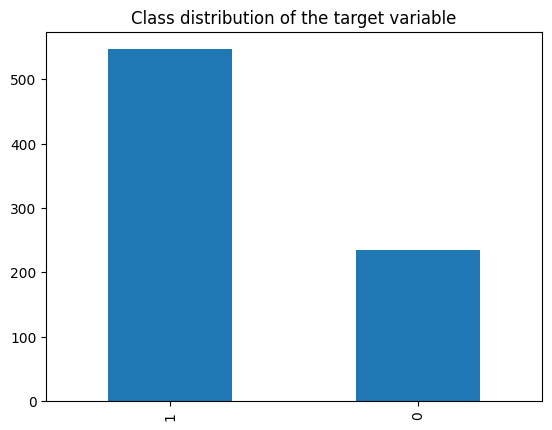

In [11]:
value_counts = y.value_counts()
value_counts.plot(kind="bar", title="Class distribution of the target variable");

We see that the training dataset is imbalanced. Moreover, the dataset is relatively small. We'll balance it and upsample the data in order to make this a more challenging problem.

We'll use the following recipe to generate the new training set:

1. Save the original training dataset in `training_set`. We do this to preserve all of the original training data. We are not upsampling this set on purpose as to prevent the leakage of synthetic data into the upsampled chunks that follow.

Repeat for N iterations:

    1. Randomly sample 300 observations from the training subset
    2. Use [SMOTEN](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTEN.html) to balance the data
    3. Append the resulting balanced partition to `training_set`


In [12]:
def generate(n_chunks, chunk_size, file_name_prefix):

    for chunk in range(n_chunks):

        print("Generating chunk {}".format(chunk))
        df_chunk = pd.DataFrame().reindex(columns=X.columns)

        while (df_chunk.shape[0] < chunk_size):
            X_sample = X.sample(300, random_state=chunk)
            y_sample = y[X_sample.index]

            sampler = SMOTEN(random_state=chunk)
            X_balanced, y_balanced = sampler.fit_resample(X_sample, y_sample)

            df_chunk = pd.concat([df_chunk, pd.concat([X_balanced, y_balanced], axis=1)], axis=0)


        df_chunk["credit"] =df_chunk["credit"].astype(int)
        df_chunk.head(chunk_size).to_csv(file_name_prefix + str(chunk) + ".csv", sep=",", header=True, index=False)
        
    print("Number of samples in the generated set is: {:,}".format(n_chunks * chunk_size))

In [13]:
print("Generating training data using oversampling and SMOTE.")

# Generate training data
generate(21, 100000, DATA_PATH + "/data/train_data_")

print("Generating validation data using oversampling and SMOTE.")

# Generate validation data
generate(3, 100000, DATA_PATH + "/data/validation_data_")


Generating training data using oversampling and SMOTE.
Generating chunk 0
Generating chunk 1
Generating chunk 2
Generating chunk 3
Generating chunk 4
Generating chunk 5
Generating chunk 6
Generating chunk 7
Generating chunk 8
Generating chunk 9
Generating chunk 10
Generating chunk 11
Generating chunk 12
Generating chunk 13
Generating chunk 14
Generating chunk 15
Generating chunk 16
Generating chunk 17
Generating chunk 18
Generating chunk 19
Generating chunk 20
Number of samples in the generated set is: 2,100,000
Generating validation data using oversampling and SMOTE.
Generating chunk 0
Generating chunk 1
Generating chunk 2
Number of samples in the generated set is: 300,000


This concludes the data preparation aspect of the project.